In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
DENSE = False
EPS = 120
LAG = 12 + 1
SROUTE = [
    '400860-400861', 
#     '400861-403781',
#     '400861-400948',
#     '400861-405376',
]
HSIZE = 128
STOPS = len(SROUTE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
dset = SpotHistory(SROUTE, 'train', 16, lag=LAG, res=10).generator()
evalset = SpotHistory(SROUTE, 'test', 16, lag=LAG, res=10).generator()

Chunks (lag 13)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
 [*] Examples (train): 11749
 [*] Time range: 2014-08-01 ~ 2014-10-31
Chunks (lag 13)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
 [*] Examples (test): 11749
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [5]:
from models.temporal.RNN import *
# lag = 6th timestep is predicted based on past 5 (50 mins
if not DENSE:
    model = RNN_MIN(hidden_size=HSIZE, steps=STOPS).to(device)
else:
    model = RNN(hidden_size=HSIZE, steps=STOPS).to(device)
model.device = device
criterion, opt, sch = model.params(lr=0.005)

In [6]:
# batch x timesteps x location
evf = lambda: evaluate(
    evalset, model, crit=lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0]).item())
_ = evf()

Eval loss: 104.32813           


In [7]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item()
        ))
    

    eval_mse.append(evf())
#     sys.stdout.write('\n')
    sys.stdout.flush()
    sch.step()

Eval loss: 1.39751             
Eval loss: 0.96046             
Eval loss: 0.81770             
Eval loss: 0.73260             
Eval loss: 0.66814             
Eval loss: 0.61511             
Eval loss: 0.57108             
Eval loss: 0.53398             
Eval loss: 0.50090             
Eval loss: 0.47363              
Eval loss: 0.44894              
Eval loss: 0.42805              
Eval loss: 0.40994              
Eval loss: 0.39387              
Eval loss: 0.37891              
Eval loss: 0.36679              
Eval loss: 0.35710              
Eval loss: 0.34481              
Eval loss: 0.33686              
Eval loss: 0.32759              
Eval loss: 0.32144              
Eval loss: 0.31392              
Eval loss: 0.30813              
Eval loss: 0.30283              
Eval loss: 0.29845              
Eval loss: 0.29728              
Eval loss: 0.29223              
Eval loss: 0.29019              
Eval loss: 0.28843              
Eval loss: 0.28736              
Eval loss: 0.28568 

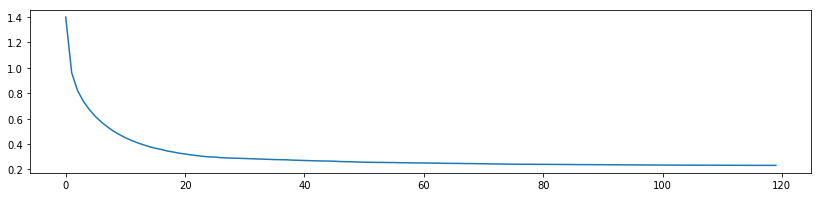

In [8]:
plt.figure(figsize=(14, 3))
plt.plot(eval_mse)
plt.show(); plt.close()

In [43]:
from utils import *
viewset = SpotHistory(SROUTE, 'test', 18, lag=None, res=10, shuffle=False, verbose=False)

sqerr = eval_rnn(viewset, model, plot=False)
print('Eval segments:', len(viewset))
print('Eval MSE: %.4f' % np.mean(sqerr))

Eval segments: 18
Eval MSE: 0.2497


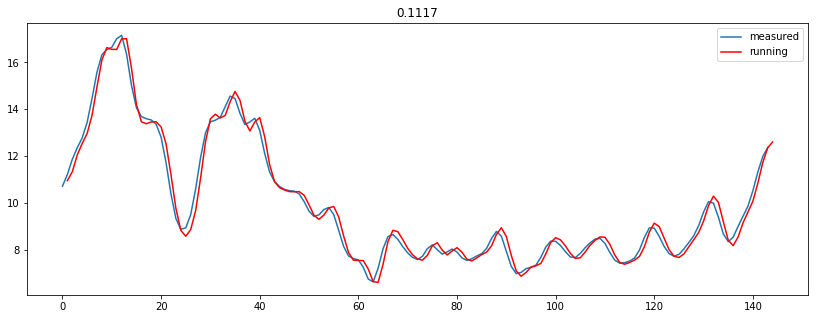

In [44]:
_ = eval_rnn(viewset[:1], model, plot=True)